In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
# from read_fk_table import get_fk_table
from read_faserv_pdf import read_pdf
# from read_LHEF import read_LHEF_data
from data_errors import compute_errors
from MC_data_reps import generate_MC_replicas
from postfit_criteria import Postfit
from form_loss_fct import complete_loss_fct, raw_loss_fct
from postfit_measures import Measures
from logspace_grid import generate_grid
from rebin_fk_data import rebin_fk
from read_data_with_fk import read_LHEF_data, get_fk_table

In [2]:
# Define global variables
num_obs = 1 #between 1 and 4
REPLICAS  = 10

#HYPERPARAMETERS
preproc = 1
l1 = 3
l2 = 3
l3 = 3

fit_level = 2
# lr = 1e-3
lr = 0.05
max_counter = 50
max_Nepochs = 3500

In [3]:
# data,data_min,data_max,xvals_per_obs,binwidths,xlabels,events_per_obs,fk_tables,x_alphas = rebin_fk(rebin=1)
data, data_min, data_max, xvals_per_obs, binwidths, xlabels, events_per_obs = (
        read_LHEF_data()
    )
x_alphas, fk_tables = get_fk_table()


In [4]:

#Get errors
sig_sys,sig_tot, _ = compute_errors(data,data_min,data_max)   
sig_tot = np.where(sig_tot == 0, .1, sig_tot)
cov_matrix = np.diag(sig_tot)

max_level0,min_level0 = max(data), min(data)

cov_matrix = np.linalg.inv(cov_matrix)
# cov_matrix = cov_matrix * ((max_level0 - min_level0) ** 2)

print(cov_matrix)
cov_matrix = torch.tensor(cov_matrix, dtype=torch.float32, requires_grad=False)


#Generate MC replicas of data
sig_stat = np.sqrt(data)
level0,level1,level2 = generate_MC_replicas(REPLICAS,data,sig_sys,sig_stat)
# Get faserv pdf
pdf = "faserv"
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
faser_pdf,x_faser = read_pdf(pdf,x_vals,12)

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          1.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          1.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 17.56021335  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         10.53612764
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  14.18324843]]
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


In [5]:
if fit_level ==0:
    pred = level0
if fit_level ==1:
    pred = level1
if fit_level ==2:
    pred = level2

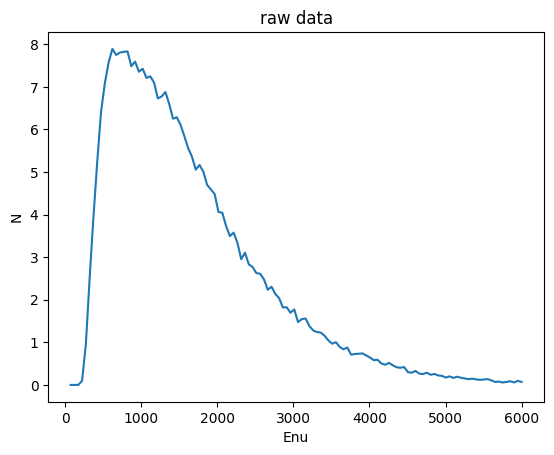

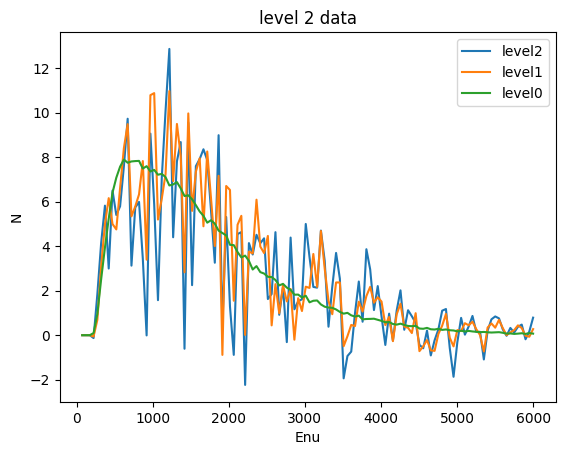

In [6]:
plt.plot(xvals_per_obs,events_per_obs)
plt.xlabel(xlabels)
plt.ylabel('N')
plt.title("raw data")
plt.show()

plt.plot(
    xvals_per_obs, level2[0], label="level2"
)
plt.plot(
    xvals_per_obs, level1[0], label="level1"
)
plt.plot(xvals_per_obs, events_per_obs,label="level0")
plt.xlabel(xlabels)
plt.legend()
plt.ylabel("N")
plt.title("level 2 data")
plt.show()


In [7]:
class SimplePerceptron(torch.nn.Module):
    def __init__(self, l1,l2,l3):
        super(SimplePerceptron, self).__init__()
        self.linear = torch.nn.Linear(1,l1)
        self.hidden = torch.nn.Linear(l1,l2)
        self.hidden2 = torch.nn.Linear(l2,l3)
        self.hidden3 = torch.nn.Linear(l3,1)
        self.relu = torch.nn.ReLU()

    def forward(self, y):
        y = self.linear(y)
        y = self.relu(y)
        y = self.hidden(y)
        y = self.relu(y)
        y = self.hidden2(y)
        y = self.relu(y)
        y = self.hidden3(y)
        y = self.relu(y)
        # y = torch.nn.functional.softplus(y)
    
        return y

In [8]:
import torch.nn as nn


        
if preproc == 1:
    class CustomPreprocessing(nn.Module):
        def __init__(self, alpha,beta,gamma):
            super(CustomPreprocessing, self).__init__()

            # self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
            # self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
            # self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))
            self.register_buffer("alpha", torch.tensor(alpha, dtype=torch.float32))
            self.register_buffer("beta", torch.tensor(beta, dtype=torch.float32))
            self.register_buffer("gamma", torch.tensor(gamma, dtype=torch.float32))


        def forward(self, x):
            # return self.gamma*(1 - x) ** abs(self.beta) * x ** (1-self.alpha)
            # alpha = (0.8*torch.tanh(self.alpha))
            # alpha = (1.6 - 0.2)/2 *torch.tanh(self.alpha) + (1.6 + 0.2)/2
            # beta = (1.9 - 0.1)/2 *torch.tanh(self.alpha) + (1.9 + 0.1)/2
            # beta = abs(self.beta)
            # return self.gamma * (1 - x) ** beta * x**(1-alpha) 
            # alpha = 1 - torch.nn.functional.softplus(self.alpha)
            # return  self.gamma*(1 - x) ** self.beta * x**(1-alpha) 
            return  (1 - x) * x 
        
    class PreprocessedMLP(nn.Module):
        def __init__(self, alpha, beta, gamma,l1, l2, l3):
            super(PreprocessedMLP, self).__init__()
            self.preprocessing = CustomPreprocessing(alpha, beta,gamma)
            self.mlp = SimplePerceptron(l1, l2, l3)

        def forward(self, x):
            f_preproc = self.preprocessing(x)
            f_NN = self.mlp(x)
            f_nu = f_preproc * f_NN
            return f_NN
        
        def neuralnet(self, x):
            f_NN = self.mlp(x)
            return f_NN
        
        def preproc(self, x):
            f_preproc = self.preprocessing(x)
            return f_preproc
        


In [9]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,pred,
    data,
    cov_matrix,last_point
    ):
        loss = raw_loss_fct(pred,
    data,
    cov_matrix,last_point)
        return loss

In [10]:
#Define variables for fit
# x_alpha_more_bins = np.logspace(-5,0,250)
# x_alpha_more_bins = torch.tensor(x_alpha_more_bins, dtype=torch.float32).view(-1,1)
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
x_vals = torch.tensor(x_vals, dtype=torch.float32).view(-1,1)
# x_vals = x_alphas
neutrino_pdfs,N_event_pred, arc_lenghts, chi_squares, int_penaltys,pos_penaltys, preproc_pdfs, nn_pdfs  = [],[],[],[],[],[],[],[]
level0_norm = (level0[0]- min_level0)/ (max_level0-min_level0)

In [11]:
def perform_fit(pred,REPLICAS):
    
        # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if preproc == 1:
            alpha,beta,gamma = 1,1,10
            model = PreprocessedMLP(alpha, beta, gamma,l1, l2, l3)

            criterion = CustomLoss()
            # criterion = torch.nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=0.01)
    for i in range(REPLICAS):
        
        losses = []
        
        # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        pred[i] = pred[i].squeeze()
        max_pred = max(pred[i])
        min_pred = min(pred[i])
        # pred[i] = (pred[i] - min(pred[i]))/ (max(pred[i])-min(pred[i]))

        model.train()

        best_loss = 1e13 # initial loss
        counter = 0
        num_epochs =  1500
        for ep in range(num_epochs):
        # while counter < max_counter:  
        #     if num_epochs>max_Nepochs:
        #         break
            
            num_epochs+=1
            optimizer.zero_grad()
            y_pred =  model(x_alphas) 
            # print(y_pred[-1])
            y_preds = torch.matmul(fk_tables,y_pred)  * binwidths 
            y_preds = y_preds.squeeze()
            last_point = model(torch.tensor([5*0.1], dtype=torch.float32).view(-1,1))
            loss= criterion(y_preds, pred[i],cov_matrix,last_point)
            # loss= criterion(y_preds, pred[i])
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            print(loss)
            # if ep % 100 == 0:
            #     pass
            # print(loss.detach().numpy())   
            if loss <.00001:
                break
            # if loss < best_loss:
            #     best_loss = loss
            #     counter = 0
            # else:
            #     counter +=1   

        if loss < 400:    
            print(num_epochs) 
        
            print(f"Constrained alpha: {(model.preprocessing.alpha.item())}")
            print(f"Constrained beta: {(model.preprocessing.beta.item())}")
            # print(f"Constrained gamma: {model.preprocessing.gamma.item()}") 


            # closure_fit = Postfit()
            # arc_lenghts.append(closure_fit.compute_arc_length(model))
            # chi_squares.append(loss.detach().numpy())

            f_nu = model(x_vals).detach().numpy().flatten() 

            preproc_pdfs.append(model.preproc(x_vals).detach().numpy().flatten())
            nn_pdfs.append(model.neuralnet(x_vals).detach().numpy().flatten())
            N_events_norm = y_preds.detach().numpy()
            N_events = N_events_norm * (max_pred.detach().numpy()- min_pred.detach().numpy()) + min_pred.detach().numpy()

            N_event_pred.append(N_events)
            plt.plot(xvals_per_obs,y_preds.detach().numpy().flatten(),label = 'nn')
            plt.plot(xvals_per_obs,pred[i],label = 'level2')
            plt.plot(xvals_per_obs,level0_norm,label = 'level0')
            plt.legend()
            plt.show()

            neutrino_pdfs.append(f_nu* (max_level0- min_level0) + min_level0)
            plt.yscale('log')
            print(f'counter = {counter}')
            plt.plot(range(1, len(losses) + 1), losses)
            plt.xlabel('#epochs')
            plt.ylabel('loss')
            plt.title('level 0 closure test, no preprocessing')
            plt.show()
            # plt.plot(x_alpha_more_bins,preproc_pdf)
            # plt.xscale('log')
            # plt.yscale('log')
            # plt.show()
    return arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model

tensor(536.4801, grad_fn=<DotBackward0>)
tensor(534.5497, grad_fn=<DotBackward0>)
tensor(532.4724, grad_fn=<DotBackward0>)
tensor(530.2167, grad_fn=<DotBackward0>)
tensor(527.7290, grad_fn=<DotBackward0>)
tensor(525.0137, grad_fn=<DotBackward0>)
tensor(522.0754, grad_fn=<DotBackward0>)
tensor(519.0178, grad_fn=<DotBackward0>)
tensor(516.0673, grad_fn=<DotBackward0>)
tensor(513.6143, grad_fn=<DotBackward0>)
tensor(512.2901, grad_fn=<DotBackward0>)
tensor(512.7410, grad_fn=<DotBackward0>)
tensor(514.4717, grad_fn=<DotBackward0>)
tensor(515.5685, grad_fn=<DotBackward0>)
tensor(515.2833, grad_fn=<DotBackward0>)
tensor(514.1724, grad_fn=<DotBackward0>)
tensor(512.9545, grad_fn=<DotBackward0>)
tensor(512.0635, grad_fn=<DotBackward0>)
tensor(511.6146, grad_fn=<DotBackward0>)
tensor(511.5238, grad_fn=<DotBackward0>)
tensor(511.6401, grad_fn=<DotBackward0>)
tensor(511.8254, grad_fn=<DotBackward0>)
tensor(511.9829, grad_fn=<DotBackward0>)
tensor(512.0574, grad_fn=<DotBackward0>)
tensor(512.0257,

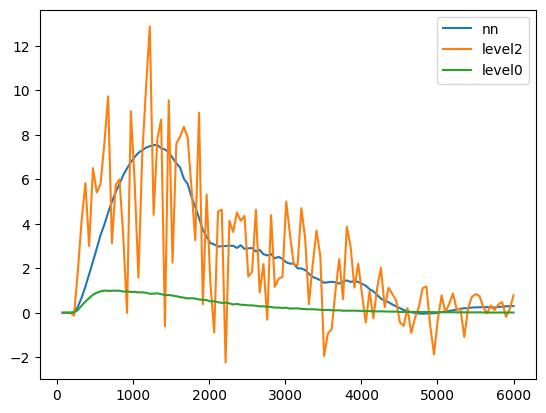

counter = 0


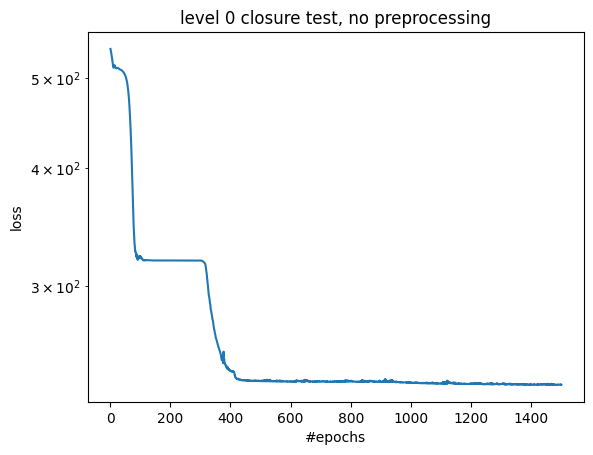

tensor(215.7737, grad_fn=<DotBackward0>)
tensor(204.6152, grad_fn=<DotBackward0>)
tensor(205.4321, grad_fn=<DotBackward0>)
tensor(209.5811, grad_fn=<DotBackward0>)
tensor(210.9590, grad_fn=<DotBackward0>)
tensor(210.6432, grad_fn=<DotBackward0>)
tensor(208.8939, grad_fn=<DotBackward0>)
tensor(206.7329, grad_fn=<DotBackward0>)
tensor(206.0439, grad_fn=<DotBackward0>)
tensor(206.8693, grad_fn=<DotBackward0>)
tensor(207.9650, grad_fn=<DotBackward0>)
tensor(207.9699, grad_fn=<DotBackward0>)
tensor(206.9854, grad_fn=<DotBackward0>)
tensor(206.1625, grad_fn=<DotBackward0>)
tensor(206.1086, grad_fn=<DotBackward0>)
tensor(206.5631, grad_fn=<DotBackward0>)
tensor(206.8437, grad_fn=<DotBackward0>)
tensor(206.5712, grad_fn=<DotBackward0>)
tensor(205.9744, grad_fn=<DotBackward0>)
tensor(205.5432, grad_fn=<DotBackward0>)
tensor(205.5564, grad_fn=<DotBackward0>)
tensor(205.8583, grad_fn=<DotBackward0>)
tensor(205.6750, grad_fn=<DotBackward0>)
tensor(205.2349, grad_fn=<DotBackward0>)
tensor(204.6665,

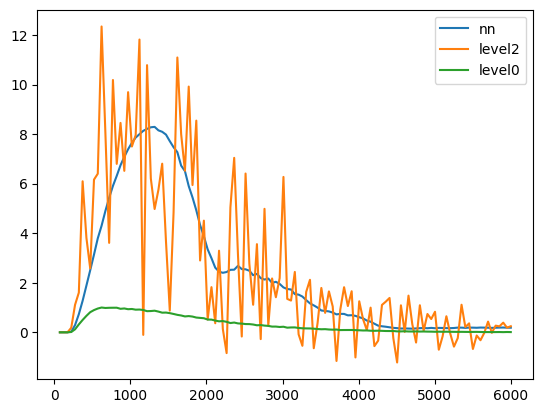

counter = 0


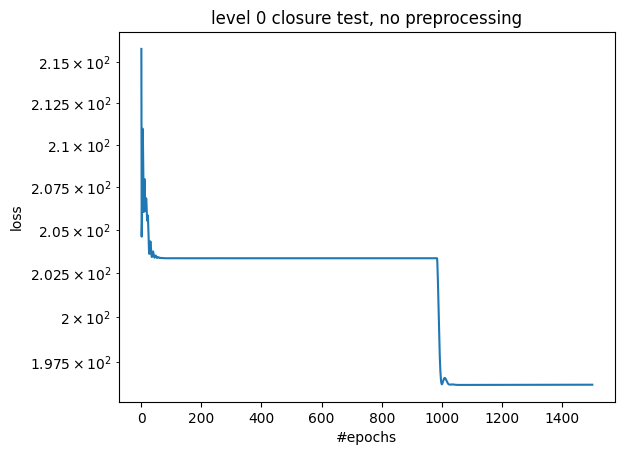

tensor(269.7325, grad_fn=<DotBackward0>)
tensor(265.3470, grad_fn=<DotBackward0>)
tensor(266.8963, grad_fn=<DotBackward0>)
tensor(262.9852, grad_fn=<DotBackward0>)
tensor(259.6863, grad_fn=<DotBackward0>)
tensor(259.7025, grad_fn=<DotBackward0>)
tensor(257.4091, grad_fn=<DotBackward0>)
tensor(255.0412, grad_fn=<DotBackward0>)
tensor(253.4539, grad_fn=<DotBackward0>)
tensor(250.0157, grad_fn=<DotBackward0>)
tensor(250.6811, grad_fn=<DotBackward0>)
tensor(248.1224, grad_fn=<DotBackward0>)
tensor(247.2358, grad_fn=<DotBackward0>)
tensor(250.3942, grad_fn=<DotBackward0>)
tensor(247.5098, grad_fn=<DotBackward0>)
tensor(247.3039, grad_fn=<DotBackward0>)
tensor(248.9258, grad_fn=<DotBackward0>)
tensor(246.1490, grad_fn=<DotBackward0>)
tensor(247.4331, grad_fn=<DotBackward0>)
tensor(251.2265, grad_fn=<DotBackward0>)
tensor(244.4321, grad_fn=<DotBackward0>)
tensor(251.6855, grad_fn=<DotBackward0>)
tensor(251.5634, grad_fn=<DotBackward0>)
tensor(244.4582, grad_fn=<DotBackward0>)
tensor(258.2689,

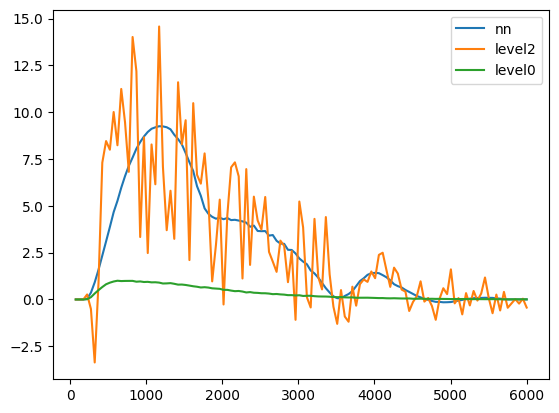

counter = 0


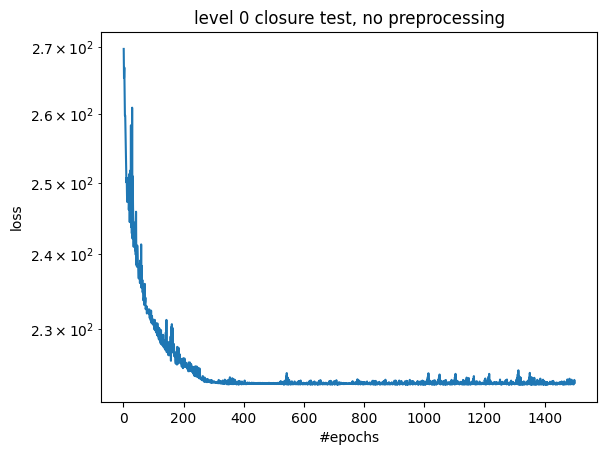

tensor(262.3454, grad_fn=<DotBackward0>)
tensor(259.3168, grad_fn=<DotBackward0>)
tensor(262.4689, grad_fn=<DotBackward0>)
tensor(258.4018, grad_fn=<DotBackward0>)
tensor(258.6329, grad_fn=<DotBackward0>)
tensor(262.6973, grad_fn=<DotBackward0>)
tensor(255.2643, grad_fn=<DotBackward0>)
tensor(255.2343, grad_fn=<DotBackward0>)
tensor(256.4442, grad_fn=<DotBackward0>)
tensor(253.1653, grad_fn=<DotBackward0>)
tensor(254.5225, grad_fn=<DotBackward0>)
tensor(248.9050, grad_fn=<DotBackward0>)
tensor(248.5515, grad_fn=<DotBackward0>)
tensor(248.1230, grad_fn=<DotBackward0>)
tensor(245.8398, grad_fn=<DotBackward0>)
tensor(246.1333, grad_fn=<DotBackward0>)
tensor(243.4912, grad_fn=<DotBackward0>)
tensor(241.9253, grad_fn=<DotBackward0>)
tensor(241.5430, grad_fn=<DotBackward0>)
tensor(240.2065, grad_fn=<DotBackward0>)
tensor(240.5151, grad_fn=<DotBackward0>)
tensor(239.1609, grad_fn=<DotBackward0>)
tensor(237.6757, grad_fn=<DotBackward0>)
tensor(237.7483, grad_fn=<DotBackward0>)
tensor(237.0300,

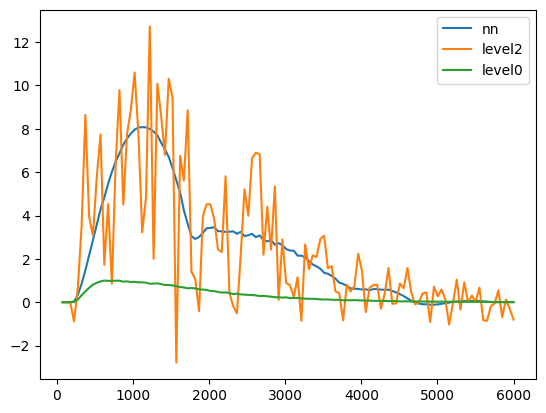

counter = 0


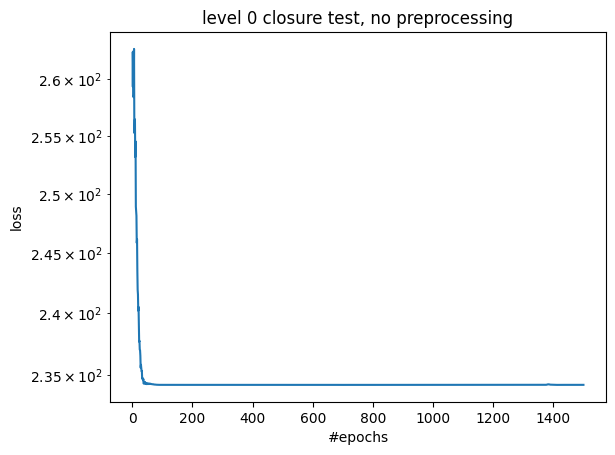

tensor(304.9272, grad_fn=<DotBackward0>)
tensor(305.9801, grad_fn=<DotBackward0>)
tensor(297.4534, grad_fn=<DotBackward0>)
tensor(302.0462, grad_fn=<DotBackward0>)
tensor(293.9117, grad_fn=<DotBackward0>)
tensor(295.9889, grad_fn=<DotBackward0>)
tensor(291.3480, grad_fn=<DotBackward0>)
tensor(289.0701, grad_fn=<DotBackward0>)
tensor(287.9467, grad_fn=<DotBackward0>)
tensor(281.2669, grad_fn=<DotBackward0>)
tensor(278.4257, grad_fn=<DotBackward0>)
tensor(277.0633, grad_fn=<DotBackward0>)
tensor(278.3869, grad_fn=<DotBackward0>)
tensor(278.8460, grad_fn=<DotBackward0>)
tensor(278.4477, grad_fn=<DotBackward0>)
tensor(276.7599, grad_fn=<DotBackward0>)
tensor(274.3757, grad_fn=<DotBackward0>)
tensor(276.8773, grad_fn=<DotBackward0>)
tensor(276.9727, grad_fn=<DotBackward0>)
tensor(276.1385, grad_fn=<DotBackward0>)
tensor(275.2101, grad_fn=<DotBackward0>)
tensor(276.7947, grad_fn=<DotBackward0>)
tensor(274.8564, grad_fn=<DotBackward0>)
tensor(276.2322, grad_fn=<DotBackward0>)
tensor(277.1753,

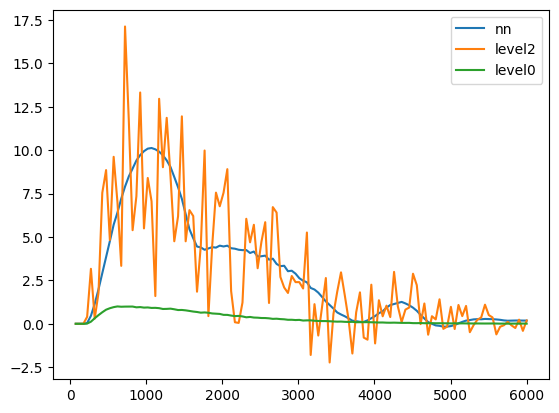

counter = 0


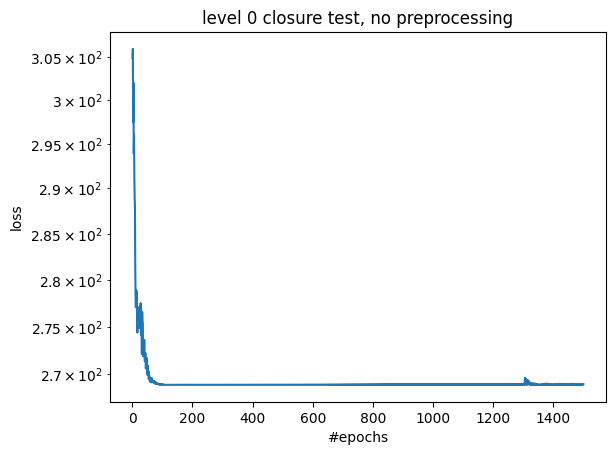

tensor(297.3856, grad_fn=<DotBackward0>)
tensor(289.6556, grad_fn=<DotBackward0>)
tensor(270.9757, grad_fn=<DotBackward0>)
tensor(274.5800, grad_fn=<DotBackward0>)
tensor(279.4700, grad_fn=<DotBackward0>)
tensor(269.9989, grad_fn=<DotBackward0>)
tensor(267.6973, grad_fn=<DotBackward0>)
tensor(248.8920, grad_fn=<DotBackward0>)
tensor(237.0885, grad_fn=<DotBackward0>)
tensor(244.8300, grad_fn=<DotBackward0>)
tensor(242.7712, grad_fn=<DotBackward0>)
tensor(240.4560, grad_fn=<DotBackward0>)
tensor(242.3003, grad_fn=<DotBackward0>)
tensor(239.7942, grad_fn=<DotBackward0>)
tensor(244.7362, grad_fn=<DotBackward0>)
tensor(241.8929, grad_fn=<DotBackward0>)
tensor(239.9366, grad_fn=<DotBackward0>)
tensor(234.7788, grad_fn=<DotBackward0>)
tensor(230.5875, grad_fn=<DotBackward0>)
tensor(229.2894, grad_fn=<DotBackward0>)
tensor(228.9794, grad_fn=<DotBackward0>)
tensor(220.1731, grad_fn=<DotBackward0>)
tensor(221.6118, grad_fn=<DotBackward0>)
tensor(221.0306, grad_fn=<DotBackward0>)
tensor(219.6382,

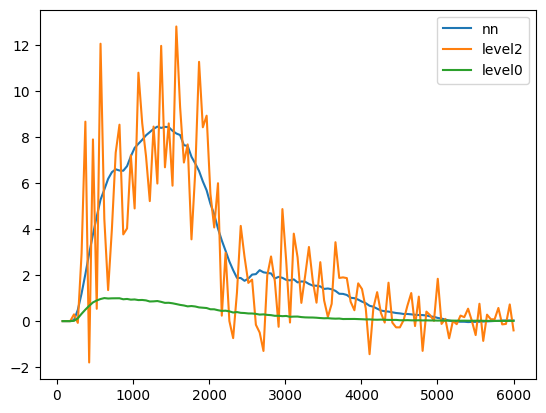

counter = 0


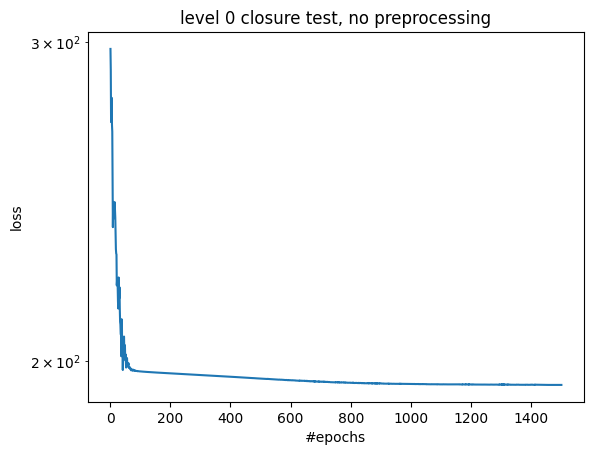

tensor(278.8048, grad_fn=<DotBackward0>)
tensor(276.9313, grad_fn=<DotBackward0>)
tensor(271.6189, grad_fn=<DotBackward0>)
tensor(273.4609, grad_fn=<DotBackward0>)
tensor(266.8583, grad_fn=<DotBackward0>)
tensor(267.0728, grad_fn=<DotBackward0>)
tensor(266.3290, grad_fn=<DotBackward0>)
tensor(263.7572, grad_fn=<DotBackward0>)
tensor(261.5325, grad_fn=<DotBackward0>)
tensor(261.2603, grad_fn=<DotBackward0>)
tensor(260.3723, grad_fn=<DotBackward0>)
tensor(259.0011, grad_fn=<DotBackward0>)
tensor(258.1504, grad_fn=<DotBackward0>)
tensor(257.9741, grad_fn=<DotBackward0>)
tensor(259.1789, grad_fn=<DotBackward0>)
tensor(258.4713, grad_fn=<DotBackward0>)
tensor(259.2838, grad_fn=<DotBackward0>)
tensor(259.2607, grad_fn=<DotBackward0>)
tensor(259.8256, grad_fn=<DotBackward0>)
tensor(260.3039, grad_fn=<DotBackward0>)
tensor(258.9943, grad_fn=<DotBackward0>)
tensor(259.8270, grad_fn=<DotBackward0>)
tensor(258.6023, grad_fn=<DotBackward0>)
tensor(258.6434, grad_fn=<DotBackward0>)
tensor(258.0222,

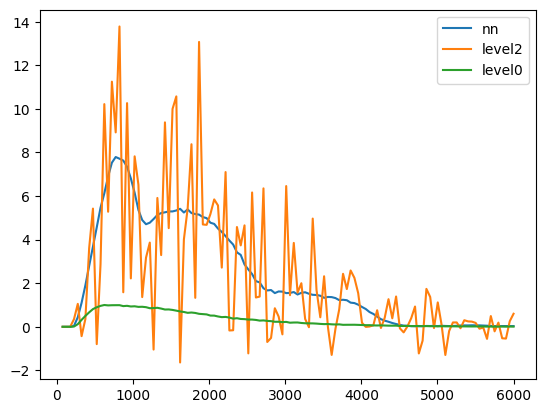

counter = 0


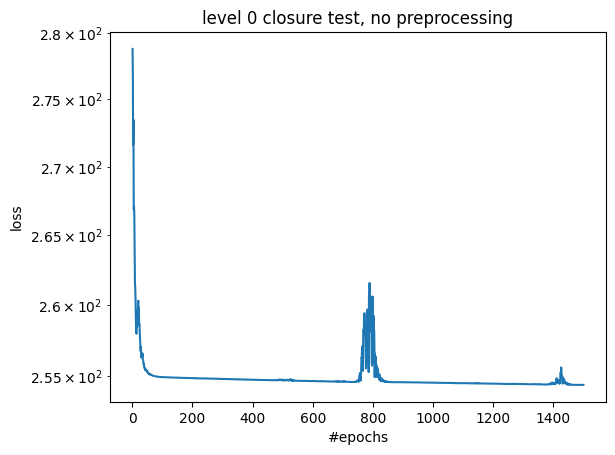

tensor(314.0839, grad_fn=<DotBackward0>)
tensor(307.7787, grad_fn=<DotBackward0>)
tensor(302.3169, grad_fn=<DotBackward0>)
tensor(298.1380, grad_fn=<DotBackward0>)
tensor(294.6272, grad_fn=<DotBackward0>)
tensor(291.7961, grad_fn=<DotBackward0>)
tensor(288.4490, grad_fn=<DotBackward0>)
tensor(284.1404, grad_fn=<DotBackward0>)
tensor(280.5767, grad_fn=<DotBackward0>)
tensor(277.3575, grad_fn=<DotBackward0>)
tensor(273.9996, grad_fn=<DotBackward0>)
tensor(271.4394, grad_fn=<DotBackward0>)
tensor(269.4974, grad_fn=<DotBackward0>)
tensor(268.0164, grad_fn=<DotBackward0>)
tensor(267.0570, grad_fn=<DotBackward0>)
tensor(267.0314, grad_fn=<DotBackward0>)
tensor(266.7839, grad_fn=<DotBackward0>)
tensor(267.3146, grad_fn=<DotBackward0>)
tensor(266.8706, grad_fn=<DotBackward0>)
tensor(266.6915, grad_fn=<DotBackward0>)
tensor(266.3944, grad_fn=<DotBackward0>)
tensor(265.6459, grad_fn=<DotBackward0>)
tensor(264.8461, grad_fn=<DotBackward0>)
tensor(263.7474, grad_fn=<DotBackward0>)
tensor(263.0689,

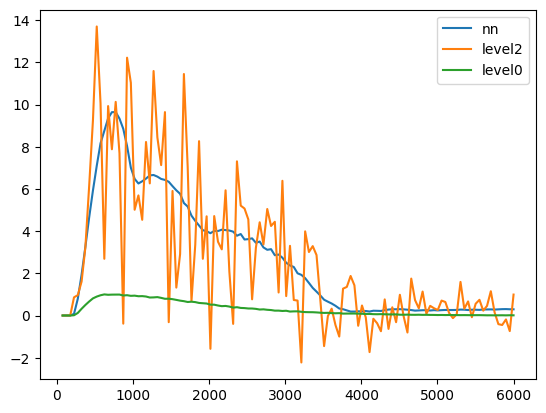

counter = 0


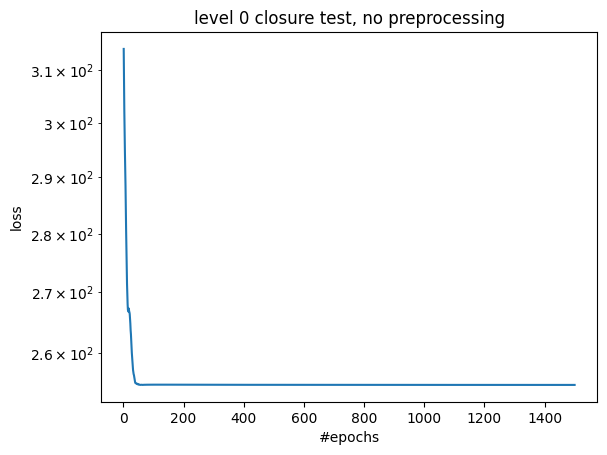

tensor(222.9574, grad_fn=<DotBackward0>)
tensor(225.8074, grad_fn=<DotBackward0>)
tensor(222.0429, grad_fn=<DotBackward0>)
tensor(228.4648, grad_fn=<DotBackward0>)
tensor(217.2464, grad_fn=<DotBackward0>)
tensor(219.1825, grad_fn=<DotBackward0>)
tensor(214.6216, grad_fn=<DotBackward0>)
tensor(219.6433, grad_fn=<DotBackward0>)
tensor(212.6014, grad_fn=<DotBackward0>)
tensor(212.7252, grad_fn=<DotBackward0>)
tensor(208.2446, grad_fn=<DotBackward0>)
tensor(210.2681, grad_fn=<DotBackward0>)
tensor(208.1363, grad_fn=<DotBackward0>)
tensor(209.9554, grad_fn=<DotBackward0>)
tensor(207.4710, grad_fn=<DotBackward0>)
tensor(208.7454, grad_fn=<DotBackward0>)
tensor(207.0120, grad_fn=<DotBackward0>)
tensor(207.6490, grad_fn=<DotBackward0>)
tensor(207.8567, grad_fn=<DotBackward0>)
tensor(209.1490, grad_fn=<DotBackward0>)
tensor(208.1284, grad_fn=<DotBackward0>)
tensor(207.8438, grad_fn=<DotBackward0>)
tensor(206.7409, grad_fn=<DotBackward0>)
tensor(206.4224, grad_fn=<DotBackward0>)
tensor(205.9967,

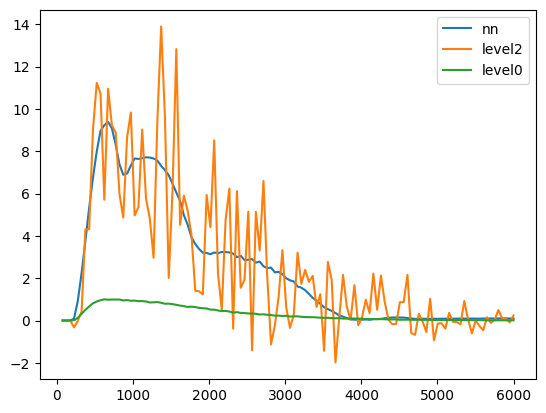

counter = 0


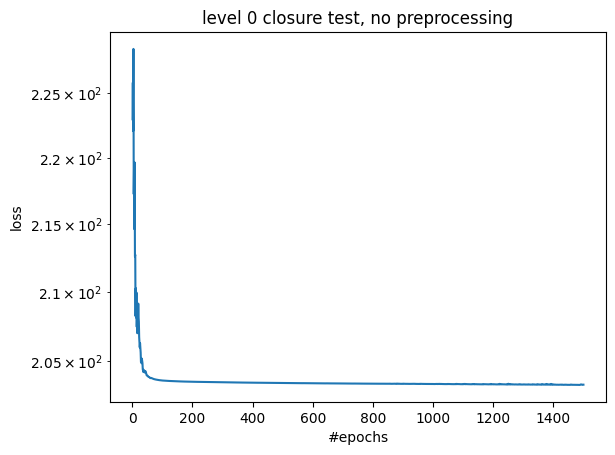

tensor(245.6489, grad_fn=<DotBackward0>)
tensor(226.7087, grad_fn=<DotBackward0>)
tensor(243.1654, grad_fn=<DotBackward0>)
tensor(257.4790, grad_fn=<DotBackward0>)
tensor(269.6050, grad_fn=<DotBackward0>)
tensor(241.2675, grad_fn=<DotBackward0>)
tensor(287.5741, grad_fn=<DotBackward0>)
tensor(226.4198, grad_fn=<DotBackward0>)
tensor(232.2157, grad_fn=<DotBackward0>)
tensor(243.6393, grad_fn=<DotBackward0>)
tensor(243.7185, grad_fn=<DotBackward0>)
tensor(248.1417, grad_fn=<DotBackward0>)
tensor(233.3537, grad_fn=<DotBackward0>)
tensor(222.7236, grad_fn=<DotBackward0>)
tensor(225.1083, grad_fn=<DotBackward0>)
tensor(231.7204, grad_fn=<DotBackward0>)
tensor(235.9210, grad_fn=<DotBackward0>)
tensor(234.9918, grad_fn=<DotBackward0>)
tensor(230.5985, grad_fn=<DotBackward0>)
tensor(225.3299, grad_fn=<DotBackward0>)
tensor(222.0462, grad_fn=<DotBackward0>)
tensor(223.8251, grad_fn=<DotBackward0>)
tensor(225.8237, grad_fn=<DotBackward0>)
tensor(227.5200, grad_fn=<DotBackward0>)
tensor(225.6221,

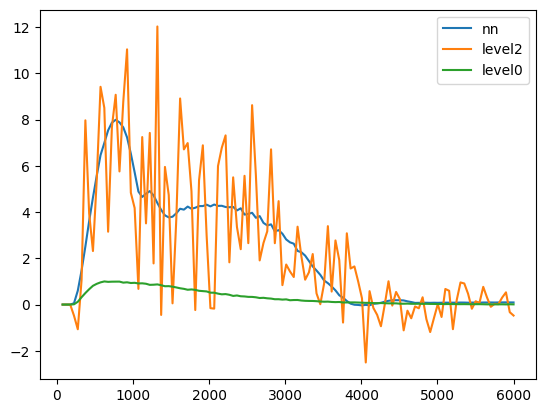

counter = 0


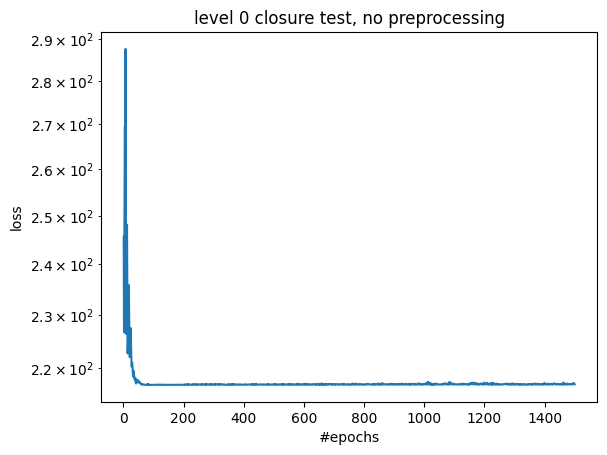

In [12]:
arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(pred,REPLICAS)

In [13]:
# closure_fit = Postfit()
# neutrino_pdfs, N_event_pred = closure_fit.apply_postfit_criteria(arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred,neutrino_pdfs)

In [14]:
# x_vals = x_vals.detach().numpy().flatten()
x_vals = x_vals.detach().numpy().flatten()
faser_pdf,x_faser = read_pdf(pdf,x_vals,12) 
mean_fnu = np.mean(neutrino_pdfs,axis=0) *x_vals

mean_pdf_preproc = np.mean(preproc_pdfs,axis=0) 
mean_nn_pdf = np.mean(nn_pdfs,axis=0) 

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


In [15]:
# from lhapdf_grid import write_lhapdf_grid
# mean_fnu = np.mean(neutrino_pdfs, axis=0) * x_vals
# lhapdfpath = '/opt/anaconda3/envs/nnpdf_dev/share/LHAPDF/enu/enu_0000.dat'

# write_lhapdf_grid(x_vals,mean_fnu,lhapdfpath)

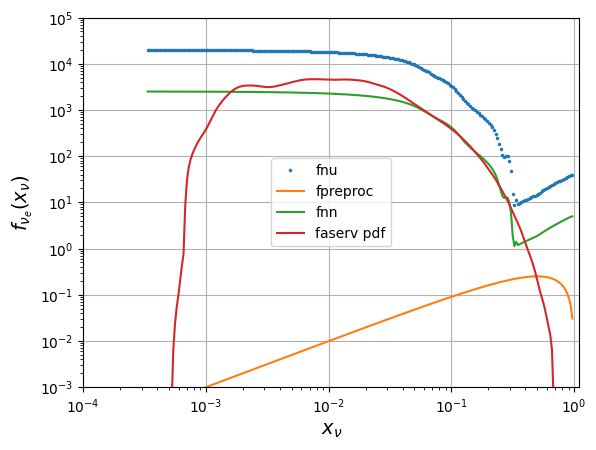

In [16]:
# plt.plot(cont_x,mean_pdf_preproc*mean_nn_pdf*(x_alpha_more_bins.detach().numpy().flatten()),label = 'mult' )
plt.plot(x_vals,mean_fnu/x_vals,'o',label="fnu",markersize=1.5)
plt.plot(x_vals,mean_pdf_preproc,label="fpreproc",markersize=1.5)
plt.plot(x_vals,mean_nn_pdf,label="fnn",markersize=1.5)
# plt.axvline(x=min(xvals_per_obs[0])/14000, color='green', linestyle='--', label='no data to the left of this line')
plt.plot(x_faser,faser_pdf,label ='faserv pdf')
plt.xlabel(r"$x_{\nu}$",fontsize = 14)
plt.ylabel(r"$f_{\nu_e}(x_{\nu})$",fontsize = 14)
plt.ylim(10**-3,10**5)
plt.xlim(10**-4,1.1)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

In [17]:
print(level0)

[tensor([0.0000, 0.0000, 0.0000, 0.0943, 0.9533, 2.5113, 3.9368, 5.2379, 6.4065,
        7.0775, 7.5728, 7.8928, 7.7510, 7.8080, 7.8244, 7.8325, 7.4868, 7.5953,
        7.3575, 7.4273, 7.2118, 7.2493, 7.1026, 6.7287, 6.7750, 6.8806, 6.5994,
        6.2542, 6.2875, 6.1078, 5.8424, 5.5604, 5.3625, 5.0568, 5.1661, 5.0116,
        4.6988, 4.5915, 4.4826, 4.0609, 4.0465, 3.7361, 3.4965, 3.5766, 3.3397,
        2.9523, 3.1049, 2.8340, 2.7708, 2.6253, 2.6122, 2.4814, 2.2367, 2.3068,
        2.1364, 2.0396, 1.8193, 1.8247, 1.6954, 1.7726, 1.4772, 1.5468, 1.5599,
        1.3811, 1.2799, 1.2428, 1.2289, 1.1557, 1.0465, 0.9680, 1.0040, 0.8923,
        0.8367, 0.8793, 0.7110, 0.7277, 0.7322, 0.7403, 0.6915, 0.6427, 0.5803,
        0.5914, 0.5024, 0.4746, 0.5174, 0.4619, 0.4143, 0.4036, 0.4190, 0.2995,
        0.2882, 0.3281, 0.2659, 0.2551, 0.2874, 0.2386, 0.2576, 0.2224, 0.2115,
        0.1736, 0.2007, 0.1654, 0.1925, 0.1681, 0.1519, 0.1356, 0.1464, 0.1302,
        0.1193, 0.1275, 0.1356, 0.1085,

LHAPDF 6.5.4 loading [0.         0.         0.         0.094313   0.95331377 2.511322
 3.9368002  5.237868   6.4064956  7.077459   7.572754   7.8927727
 7.75098    7.80799    7.824366   7.8325167  7.4868326  7.5953283
 7.357482   7.4273243  7.2117515  7.2492795  7.102587   6.7287354
 6.7750134  6.8806114  6.5993648  6.2542324  6.287479   6.107839
 5.8423715  5.5604157  5.362529   5.0568295  5.1661353  5.011607
 4.6987815  4.5914545  4.482641   4.060857   4.046506   3.736136
 3.4965472  3.5765986  3.3397493  2.9522798  3.1048992  2.8340125
 2.7707844  2.625337   2.6122084  2.4814348  2.236677   2.3067994
 2.1363928  2.0395815  1.8192859  1.824655   1.695446   1.7725506
 1.4771693  1.5468084  1.5598941  1.3811095  1.2799484  1.2428153
 1.228947   1.155658   1.0464622  0.96802026 1.0040203  0.8923118
 0.8366782  0.87928396 0.71099293 0.7277107  0.73217386 0.7403091
 0.6914975  0.64268595 0.58031553 0.59140724 0.50237155 0.47457796
 0.5174227  0.46194145 0.4143409  0.4036336  0.41897133 0.

/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:81: RuntimeWarning: divide by zero encountered in divide
  ratio_center = mean_fnu / faser_pdf
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:82: RuntimeWarning: divide by zero encountered in divide
  ratio_lower = (mean_fnu - error_fnu) / faser_pdf
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:83: RuntimeWarning: divide by zero encountered in divide
  ratio_upper = (mean_fnu + error_fnu) / faser_pdf
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:156: RuntimeWarning: divide by zero encountered in divide
  ratio_center_pred = preds_Enu / simulated_Enu
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:157: RuntimeWarning: divide by zero encountered in divide
  ratio_lower_pred = (preds_Enu - p

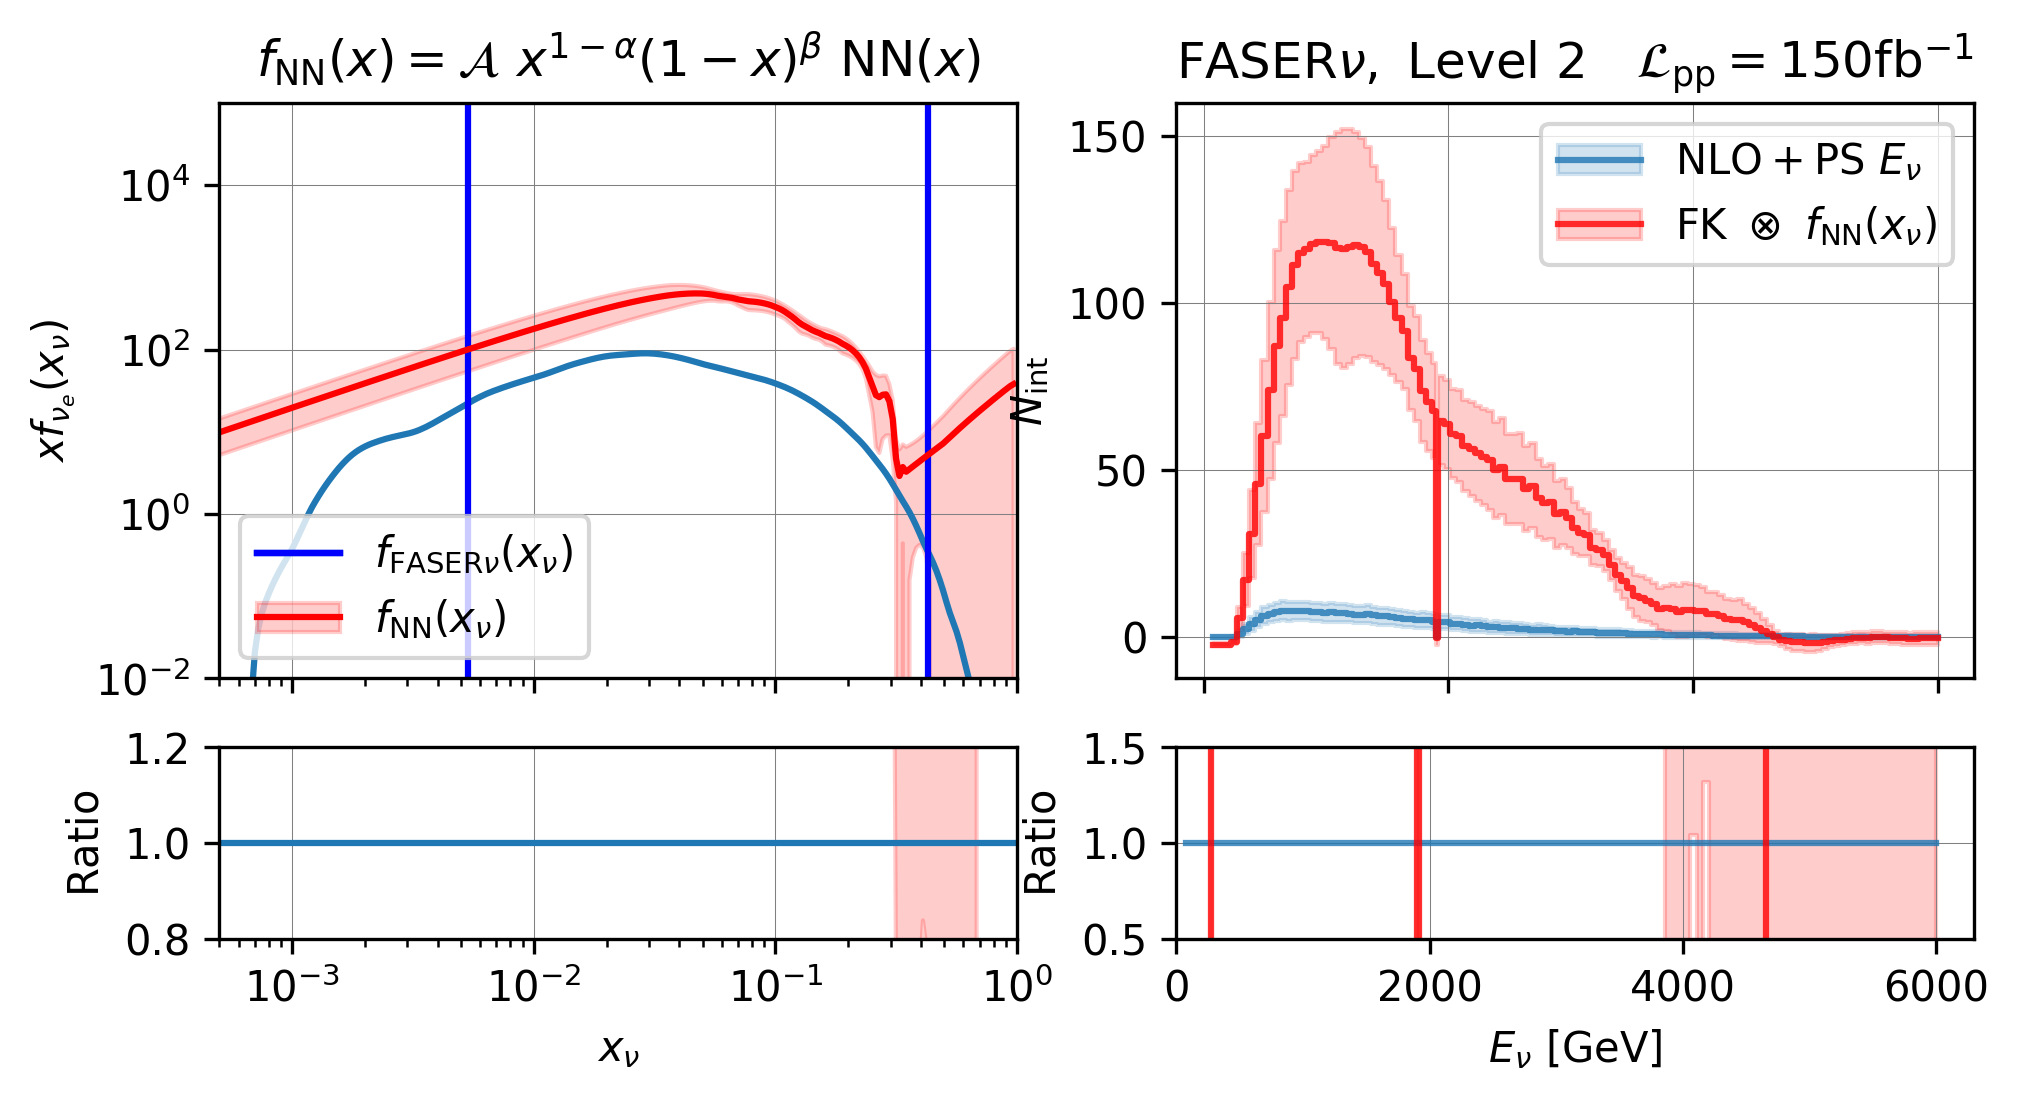

In [18]:
from plot_results import plot
# level0[0] = level0[0]* (max_level0- min_level0) + min_level0
plot(x_vals, neutrino_pdfs, level0, N_event_pred, sig_tot, xvals_per_obs,12)

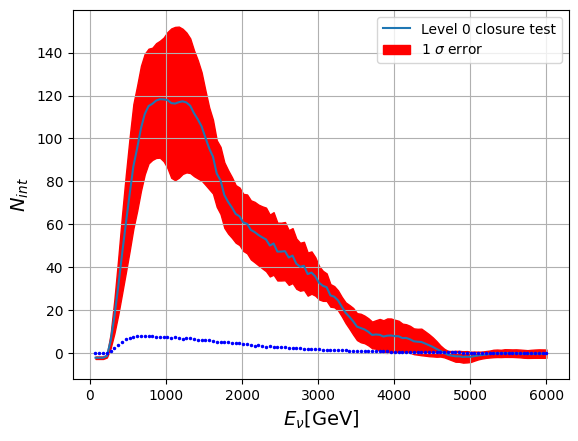

In [19]:
mean_N_event_fits = np.mean(N_event_pred,axis=0)
sigma_N_event_fits = np.std(N_event_pred,axis=0)

mean_N_event_fit = mean_N_event_fits.flatten()
sigma_N_event_fit = sigma_N_event_fits.flatten()
plt.plot(xvals_per_obs,mean_N_event_fit,label="Level 0 closure test")

plt.fill_between(xvals_per_obs,(mean_N_event_fit+sigma_N_event_fit),(mean_N_event_fit-sigma_N_event_fit),label=r"1 $\sigma$ error",color = 'red')

# plt.plot(xvals_per_obs[i],events_per_obs[i],'go',markersize=1.5)
plt.plot(xvals_per_obs,level0[0],'bo',markersize=1.5)
# plt.errorbar(xvals_per_obs[i],events_per_obs[i],yerr=np.sqrt(sig_tot),label='POWHEG +PY8 NLO',color = 'green',alpha=0.6 )
# plt.fill_between(xvals_per_obs[i],events_per_obs[i]+np.sqrt(sig_tot), events_per_obs[i]-np.sqrt(sig_tot),color = 'green',alpha=0.6)
plt.xlabel(r"$E_{\nu}$[GeV]",fontsize = 14)
plt.ylabel(r"$N_{int}$",fontsize = 14)
plt.grid()
plt.legend()
# plt.savefig('N_int_fit.pdf')
plt.show()
    

In [20]:
# Quantitative validation of PDF uncertainties in closure tests
# theoretical prediction for # of events
pdf = "faserv"
lowx = -8
n=50
# x_vals = generate_grid(lowx,n)

faser_pdf,x_faser = read_pdf(pdf,x_vals)
postfit_measures = Measures(cov_matrix, pdf, N_event_pred)
delta_chi = postfit_measures.compute_delta_chi(num_obs, fk_tables, binwidths, level1[0],x_vals)
print(f'delta chi^2 = {delta_chi}')

phi_chi_squared = postfit_measures.compute_phi(data, chi_squares)
print(f'phi level 2 = {phi_chi_squared}')

dist,xnu  = postfit_measures.compute_distance(neutrino_pdfs,x_vals)
plt.plot(xnu,dist,'o')
plt.ylabel('distance to truth')
plt.xlabel('xnu')
plt.show()

TypeError: read_pdf() missing 1 required positional argument: 'particle'

In [ ]:
def compute_accuracy():
    log_spaced = np.logspace(np.log10(1e-5), np.log10(0.1), 10)
    linear_spaced = np.linspace(0.1, 1, 10)
    x_xi_measure = np.concatenate((log_spaced, linear_spaced))
    x_xi_measure= torch.tensor(x_xi_measure, dtype=torch.float32).view(-1,1)

    pdf = "faserv"

    faser_pdf,x_faser = read_pdf(pdf,x_xi_measure)
    faser_pdf =faser_pdf.detach().numpy().squeeze()

    arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level1,REPLICAS=  1)
    mean_neutrino_pdf =model(x_xi_measure).detach().numpy().squeeze()
    
    return mean_neutrino_pdf,faser_pdf,n

# mean_neutrino_pdf,faser_pdf,n = compute_accuracy()
# xi = np.sum(abs(mean_neutrino_pdf-faser_pdf) < error_neutrino_fit)/ n
# print(f'xi = {xi}')

In [ ]:
def compute_bias_to_variance(num_level1_shifts,level0,level1,level2):
    biases = []
    variances = []
    level1 = np.array(level1)
    level0 = np.array(level0)
    diff_level01 = level1 - level0
    level2 -= diff_level01
    level0 = torch.tensor(level0, dtype=torch.float32)
    for i in range(num_level1_shifts):
        
        # generate level2 data with different level 1 shifts
        r_sys = np.random.normal(0, 1) * sig_sys / 10
        r_stat = np.random.normal(0, 1) * np.sqrt(data) / 10
        level2 += r_sys + r_stat
        level2 = torch.tensor(level2, dtype=torch.float32)
        
        arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level2,REPLICAS = 3)
        mean_N_events = np.mean(N_event_pred,axis=0)
        mean_N_events = torch.tensor(mean_N_events, dtype=torch.float32)
        
        mean_chi_square = raw_loss_fct(level0[0],mean_N_events,cov_matrix)
        biases.append(mean_chi_square)

        chi_square_level2 = 0
        for j in range (REPLICAS):
            chi_square_level2 += raw_loss_fct(level2[j],mean_N_events, cov_matrix)
        variances.append(chi_square_level2/REPLICAS)


    exp_bias = np.mean(biases)
    exp_variance = np.mean(variances)
    ratio = exp_bias/exp_variance
    return ratio
    
# ratio = compute_bias_to_variance(1,level0,level1,level2)
# print(f'ratio = {ratio}')


#BIAS:
    # mc reps = level 1 + level 2
    # average over level 1: keep level 2 the same, but add different level 1 shifts
    # compute reduced chi square with respect to level 0 data
    # VARIANCE:
    # mc reps = level 1 + level 2
    # average chi^2 over several level 2 shifts
    # do not average over level 1 shifts since it is expected to be constant
    # Compute reduced chi square with respect to all level 2 replics: so do not have to run a lot more fits it seems
    # however since these multiple level 1 fits have to be run anyway, it is no problemo